## 🔧 Automating Casting Defect Detection with Deep Learning

Manual inspection of metal castings in manufacturing is labor-intensive, time-consuming, and costly - often requiring trained personnel to visually assess thousands of parts per day. Even with expert inspectors, human error and fatigue can lead to inconsistent results and missed defects.

This project aims to **automate the defect detection process using computer vision and deep learning**, significantly reducing operational costs while increasing speed, consistency, and accuracy. By training a convolutional neural network on labeled casting images, the model learns to distinguish between **defective** and **non-defective** parts - enabling real-time quality control with minimal human intervention.

For more information about the data utilized in this project click [here.](https://www.kaggle.com/datasets/ravirajsinh45/real-life-industrial-dataset-of-casting-product)

In [1]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128
!pip install shap

Looking in indexes: https://download.pytorch.org/whl/cu128


In [2]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader, ConcatDataset, random_split
from torchvision import datasets, transforms
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
import shap
from torchvision.models import resnet18, ResNet18_Weights
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision.models.resnet as resnet_mod

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())  # Should be True
print(torch.cuda.get_device_name(0))  # Should print your GPU model

2.7.1+cu128
True
NVIDIA GeForce RTX 3070 Ti Laptop GPU


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [5]:
train_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(300, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
train_path_main = 'data/casting_data/casting_data/train'
train_path_extra = 'data/casting_512x512/casting_512x512'
test_path = 'data/casting_data/casting_data/test'

train_main = datasets.ImageFolder(train_path_main, transform=train_transform)
train_extra = datasets.ImageFolder(train_path_extra, transform=train_transform)
test_data = datasets.ImageFolder(test_path, transform=test_transform)

combined_train = ConcatDataset([train_main, train_extra])

train_size = int(0.8 * len(combined_train))
val_size = len(combined_train) - train_size
train_data, val_data = random_split(combined_train, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=32, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=32, pin_memory=True)

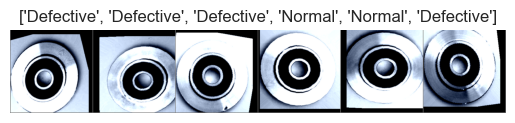

In [7]:
def imshow(img, title=None):
    img = img / 2 + 0.5
    npimg = img.numpy().transpose((1, 2, 0))
    npimg = np.clip(npimg, 0, 1)
    plt.imshow(npimg)
    if title:
        plt.title(title)
    plt.axis('off')

dataiter = iter(DataLoader(train_main, batch_size=6, shuffle=True))
images, labels = next(dataiter)
mapped_titles = []
for l in labels:
    if l.item() == 1:
        mapped_titles.append('Normal')
    elif l.item() == 0:
        mapped_titles.append('Defective')
    else:
        mapped_titles.append(str(l.item()))
imshow(torchvision.utils.make_grid(images), title=mapped_titles)
plt.show()

In [8]:
print(train_main.class_to_idx)

{'def_front': 0, 'ok_front': 1}


In [9]:
weights = ResNet18_Weights.IMAGENET1K_V1
model = resnet18(weights=weights)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1),
    nn.Sigmoid()
)
model = model.to(device)

In [10]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [11]:
num_epochs = 15
patience = 3
best_loss = float('inf')
counter = 0
train_metrics = {'loss': [], 'acc': [], 'prec': [], 'rec': [], 'auc': []}
val_metrics = {'loss': [], 'acc': [], 'prec': [], 'rec': [], 'auc': []}
for epoch in range(num_epochs):
    model.train()
    y_true_train, y_pred_train, losses = [], [], []
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        y_true_train += labels.cpu().numpy().flatten().tolist()
        y_pred_train += outputs.detach().cpu().numpy().flatten().tolist()
    y_pred_train_bin = [1 if p > 0.5 else 0 for p in y_pred_train]
    train_metrics['loss'].append(np.mean(losses))
    train_metrics['acc'].append(accuracy_score(y_true_train, y_pred_train_bin))
    train_metrics['prec'].append(precision_score(y_true_train, y_pred_train_bin))
    train_metrics['rec'].append(recall_score(y_true_train, y_pred_train_bin))
    train_metrics['auc'].append(roc_auc_score(y_true_train, y_pred_train))
    model.eval()
    y_true_val, y_pred_val, val_losses = [], [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_losses.append(loss.item())
            y_true_val += labels.cpu().numpy().flatten().tolist()
            y_pred_val += outputs.cpu().numpy().flatten().tolist()
    y_pred_val_bin = [1 if p > 0.5 else 0 for p in y_pred_val]
    val_loss_mean = np.mean(val_losses)
    val_metrics['loss'].append(val_loss_mean)
    val_metrics['acc'].append(accuracy_score(y_true_val, y_pred_val_bin))
    val_metrics['prec'].append(precision_score(y_true_val, y_pred_val_bin))
    val_metrics['rec'].append(recall_score(y_true_val, y_pred_val_bin))
    val_metrics['auc'].append(roc_auc_score(y_true_val, y_pred_val))
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_metrics['loss'][-1]:.4f} | "
          f"Val Loss: {val_loss_mean:.4f}")
    print(f"Val Acc: {val_metrics['acc'][-1]:.4f} | "
          f"Prec: {val_metrics['prec'][-1]:.4f} | "
          f"Rec: {val_metrics['rec'][-1]:.4f} | "
          f"AUC: {val_metrics['auc'][-1]:.4f}")
    if val_loss_mean < best_loss:
        best_loss = val_loss_mean
        counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

Epoch 1/15
Train Loss: 0.0956 | Val Loss: 0.0242
Val Acc: 0.9918 | Prec: 0.9849 | Rec: 0.9954 | AUC: 0.9996
Epoch 2/15
Train Loss: 0.0309 | Val Loss: 0.0152
Val Acc: 0.9943 | Prec: 0.9894 | Rec: 0.9969 | AUC: 0.9998
Epoch 3/15
Train Loss: 0.0289 | Val Loss: 0.0159
Val Acc: 0.9943 | Prec: 0.9879 | Rec: 0.9985 | AUC: 0.9999
Epoch 4/15
Train Loss: 0.0161 | Val Loss: 0.0127
Val Acc: 0.9968 | Prec: 0.9924 | Rec: 1.0000 | AUC: 0.9998
Epoch 5/15
Train Loss: 0.0144 | Val Loss: 0.0159
Val Acc: 0.9956 | Prec: 0.9954 | Rec: 0.9939 | AUC: 0.9999
Epoch 6/15
Train Loss: 0.0169 | Val Loss: 0.0119
Val Acc: 0.9956 | Prec: 0.9894 | Rec: 1.0000 | AUC: 0.9999
Epoch 7/15
Train Loss: 0.0218 | Val Loss: 0.0114
Val Acc: 0.9962 | Prec: 0.9909 | Rec: 1.0000 | AUC: 0.9999
Epoch 8/15
Train Loss: 0.0140 | Val Loss: 0.0154
Val Acc: 0.9943 | Prec: 0.9864 | Rec: 1.0000 | AUC: 0.9999
Epoch 9/15
Train Loss: 0.0118 | Val Loss: 0.0099
Val Acc: 0.9975 | Prec: 0.9939 | Rec: 1.0000 | AUC: 0.9999
Epoch 10/15
Train Loss: 0.01

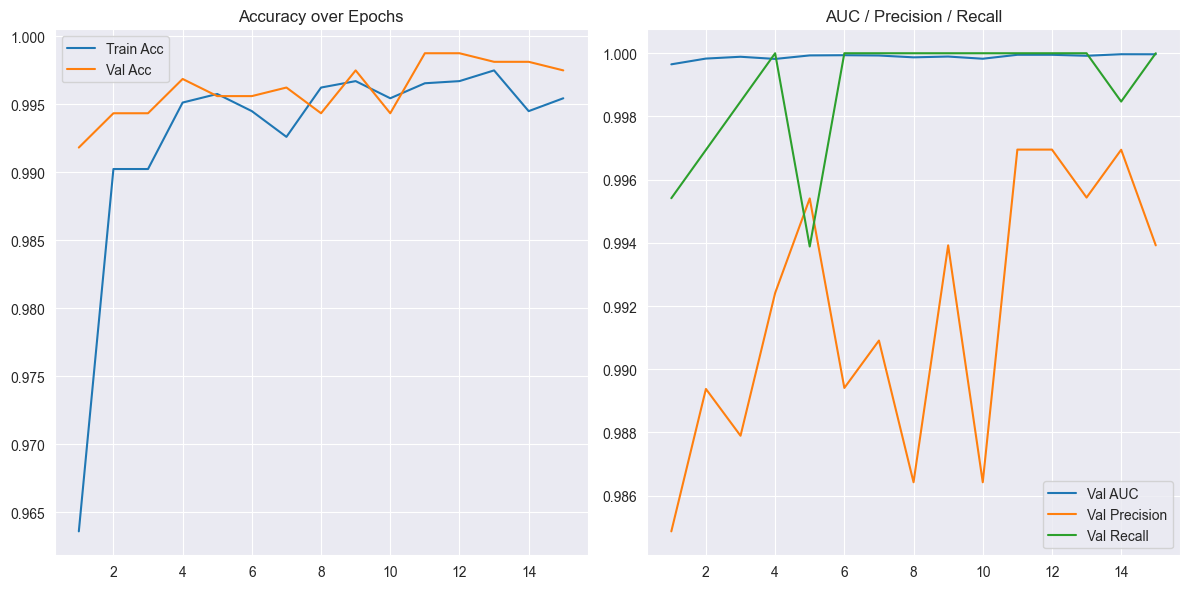

In [12]:
epochs_ran = len(train_metrics['loss'])
x = list(range(1, epochs_ran + 1))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(x, train_metrics['acc'], label='Train Acc')
plt.plot(x, val_metrics['acc'], label='Val Acc')
plt.title("Accuracy over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x, val_metrics['auc'], label='Val AUC')
plt.plot(x, val_metrics['prec'], label='Val Precision')
plt.plot(x, val_metrics['rec'], label='Val Recall')
plt.title("AUC / Precision / Recall")
plt.legend()

plt.tight_layout()
plt.show()

Test Accuracy: 0.9986013986013986
Test Precision: 0.9961977186311787
Test Recall: 1.0
Test AUC: 1.0


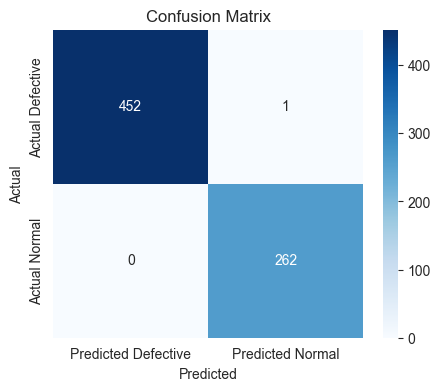

In [13]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()
y_true_test, y_pred_test = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        outputs = model(images)
        y_true_test += labels.cpu().numpy().tolist()
        y_pred_test += outputs.cpu().numpy().flatten().tolist()
y_pred_test_bin = [1 if p > 0.5 else 0 for p in y_pred_test]
print("Test Accuracy:", accuracy_score(y_true_test, y_pred_test_bin))
print("Test Precision:", precision_score(y_true_test, y_pred_test_bin))
print("Test Recall:", recall_score(y_true_test, y_pred_test_bin))
print("Test AUC:", roc_auc_score(y_true_test, y_pred_test))
cm = confusion_matrix(y_true_test, y_pred_test_bin)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Defective', 'Predicted Normal'],
            yticklabels=['Actual Defective', 'Actual Normal'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [14]:
plt.style.use('default')
sns.set_palette("husl")
def basicblock_forward(self, x):
    identity = x
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)
    out = self.conv2(out)
    out = self.bn2(out)
    if self.downsample is not None:
        identity = self.downsample(x)
    out = out + identity
    out = self.relu(out)
    return out

resnet_mod.BasicBlock.forward = basicblock_forward

def set_relu_inplace(module):
    for child in module.children():
        if isinstance(child, torch.nn.ReLU):
            child.inplace = False
        else:
            set_relu_inplace(child)

set_relu_inplace(model)

In [15]:
n_samples = 3
defective_indices = []
normal_indices = []
for idx, (img, label) in enumerate(test_data):
    if label == 0 and len(defective_indices) < n_samples:
        defective_indices.append(idx)
    elif label == 1 and len(normal_indices) < n_samples:
        normal_indices.append(idx)
    if len(defective_indices) == n_samples and len(normal_indices) == n_samples:
        break

selected_indices = defective_indices + normal_indices
selected_imgs = torch.stack([test_data[i][0] for i in selected_indices]).to(device)
selected_labels = [test_data[i][1] for i in selected_indices]
background_indices = random.sample(range(len(test_data)), 50)
background = torch.stack([test_data[i][0] for i in background_indices]).to(device)
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(selected_imgs, check_additivity=False)
imgs_np = selected_imgs.cpu().numpy().transpose(0, 2, 3, 1)  # (N, H, W, C)
imgs_np = np.clip(imgs_np, 0, 1).astype(np.float32)
shap_vals_defective = shap_values[:, 0, :, :, 0]
shap_vals_normal = shap_values[:, 1, :, :, 0]
labels = [f"{'Defective' if l==0 else 'Normal'}" for l in selected_labels]

🔍 Creating SHAP Analysis Visualizations...

1. Overview of All Samples:


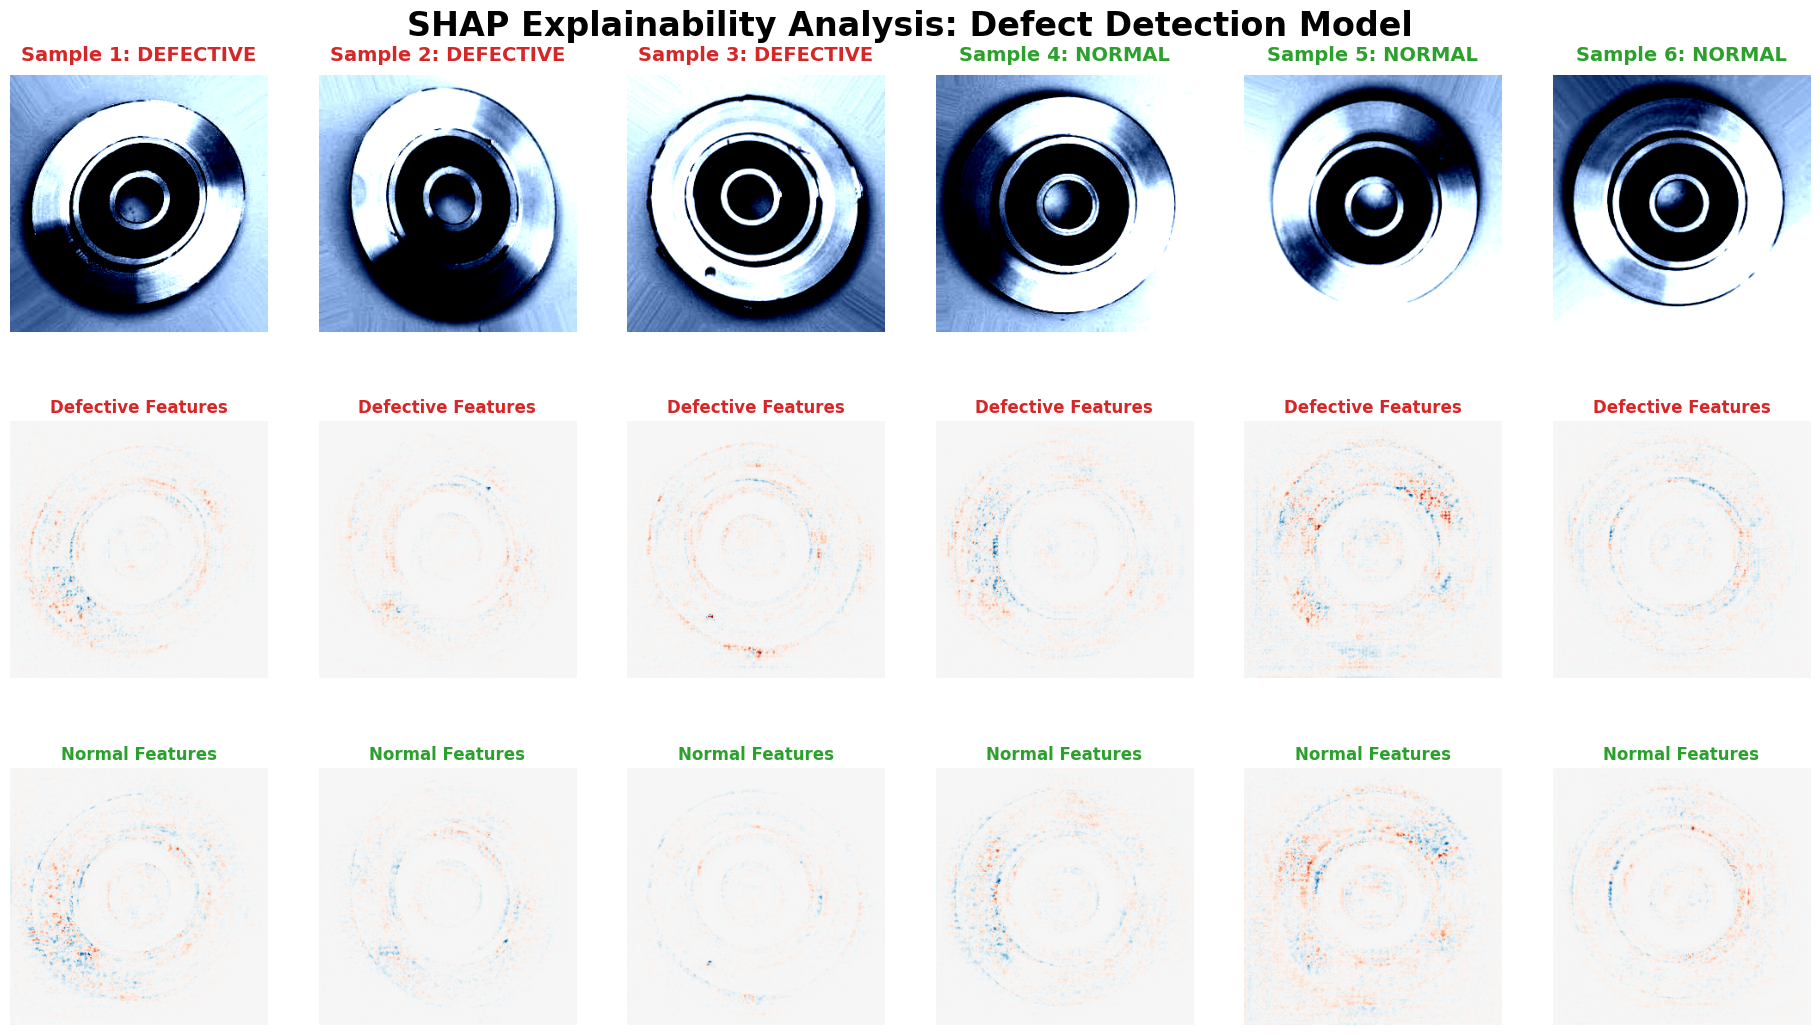

• Red regions indicate features that SUPPORT the prediction
• Blue regions indicate features that OPPOSE the prediction


In [16]:
print("🔍 Creating SHAP Analysis Visualizations...")
print("\n1. Overview of All Samples:")
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 6, height_ratios=[1, 1, 1], hspace=0.3, wspace=0.2)
fig.suptitle('SHAP Explainability Analysis: Defect Detection Model\n', fontsize=24, fontweight='bold', y=0.95)
defective_color = '#d62728'  # Red
normal_color = '#2ca02c'     # Green
for i in range(6):
   label = selected_labels[i]
   img = imgs_np[i]
   shap_def = shap_vals_defective[i]
   shap_norm = shap_vals_normal[i]
   border_color = defective_color if label == 0 else normal_color
   label_text = "DEFECTIVE" if label == 0 else "NORMAL"
   ax1 = fig.add_subplot(gs[0, i])
   ax1.imshow(img)
   ax1.set_title(f'Sample {i+1}: {label_text}', fontsize=14, fontweight='bold',
                color=border_color, pad=10)
   ax1.axis('off')
   for spine in ax1.spines.values():
       spine.set_edgecolor(border_color)
       spine.set_linewidth(3)
       spine.set_visible(True)
   ax2 = fig.add_subplot(gs[1, i])
   max_val = np.abs(shap_def).max()
   im2 = ax2.imshow(shap_def, cmap='RdBu_r', vmin=-max_val, vmax=max_val)
   ax2.set_title('Defective Features', fontsize=12, color=defective_color, fontweight='bold')
   ax2.axis('off')
   ax3 = fig.add_subplot(gs[2, i])
   max_val = np.abs(shap_norm).max()
   im3 = ax3.imshow(shap_norm, cmap='RdBu_r', vmin=-max_val, vmax=max_val)
   ax3.set_title('Normal Features', fontsize=12, color=normal_color, fontweight='bold')
   ax3.axis('off')
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1, hspace=0.3, wspace=0.2)
plt.show()
print("• Red regions indicate features that SUPPORT the prediction")
print("• Blue regions indicate features that OPPOSE the prediction")

Individual Analysis:


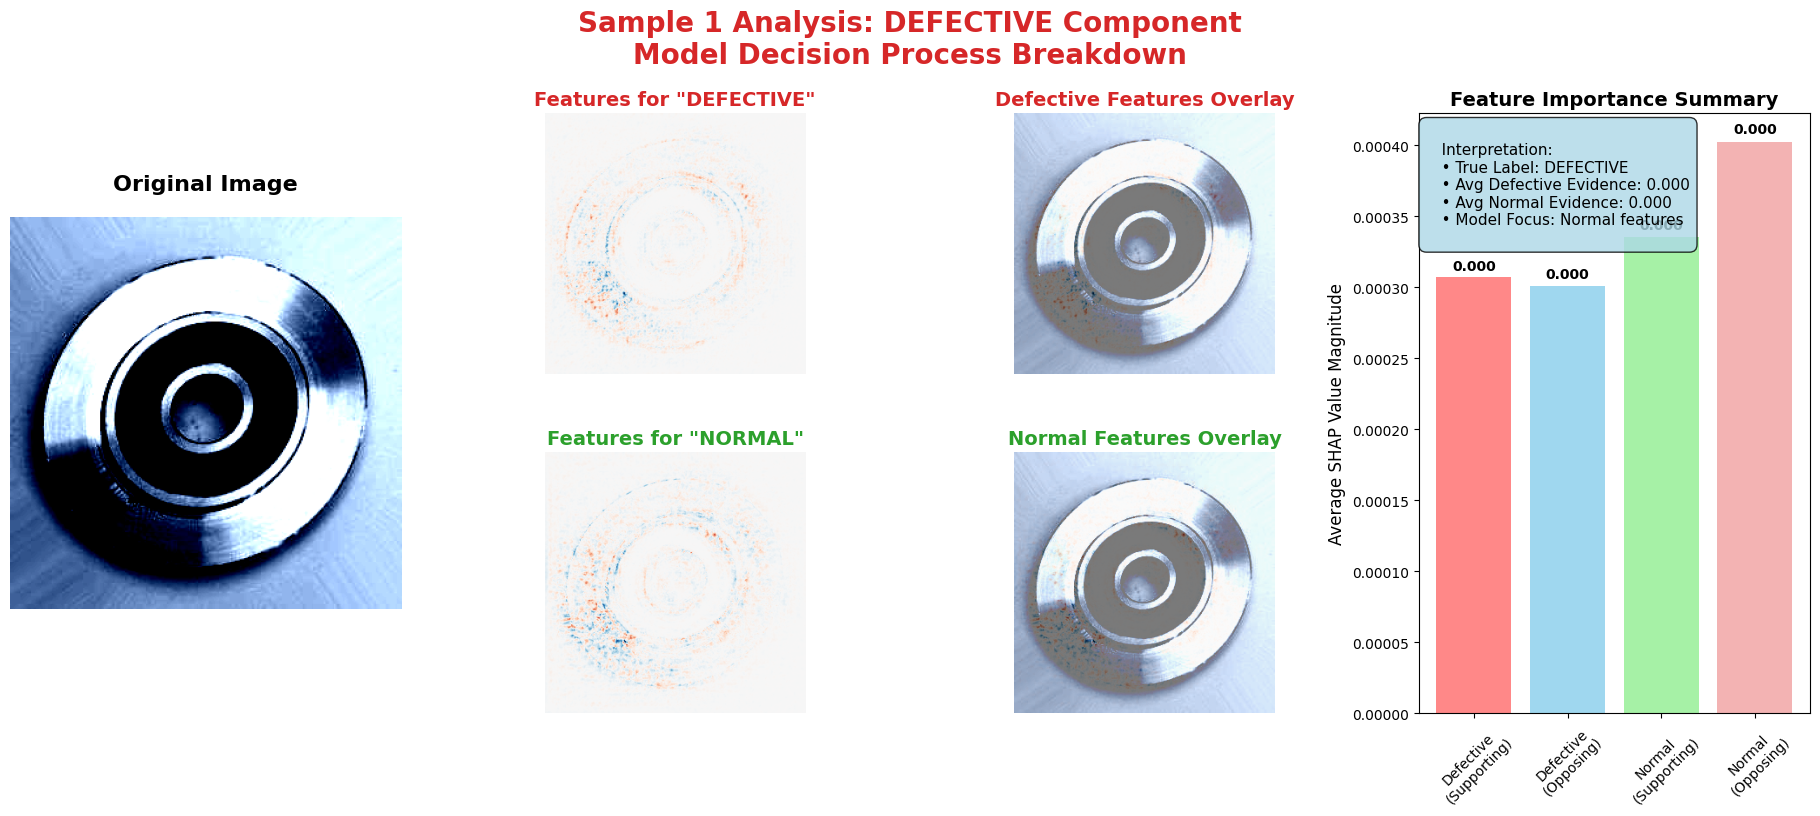

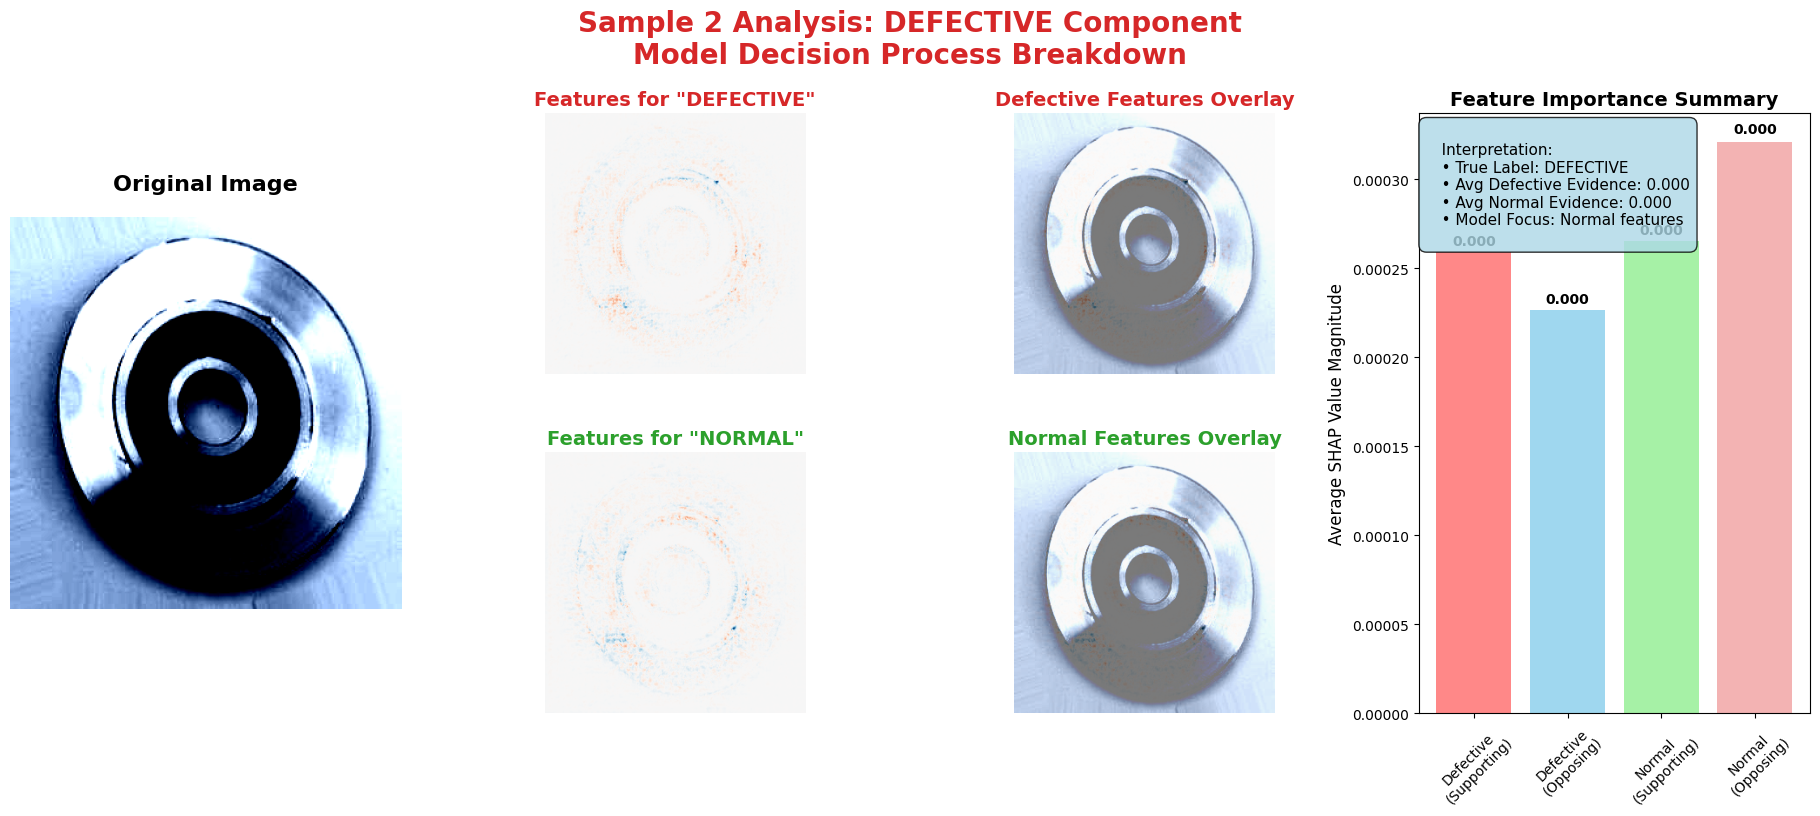

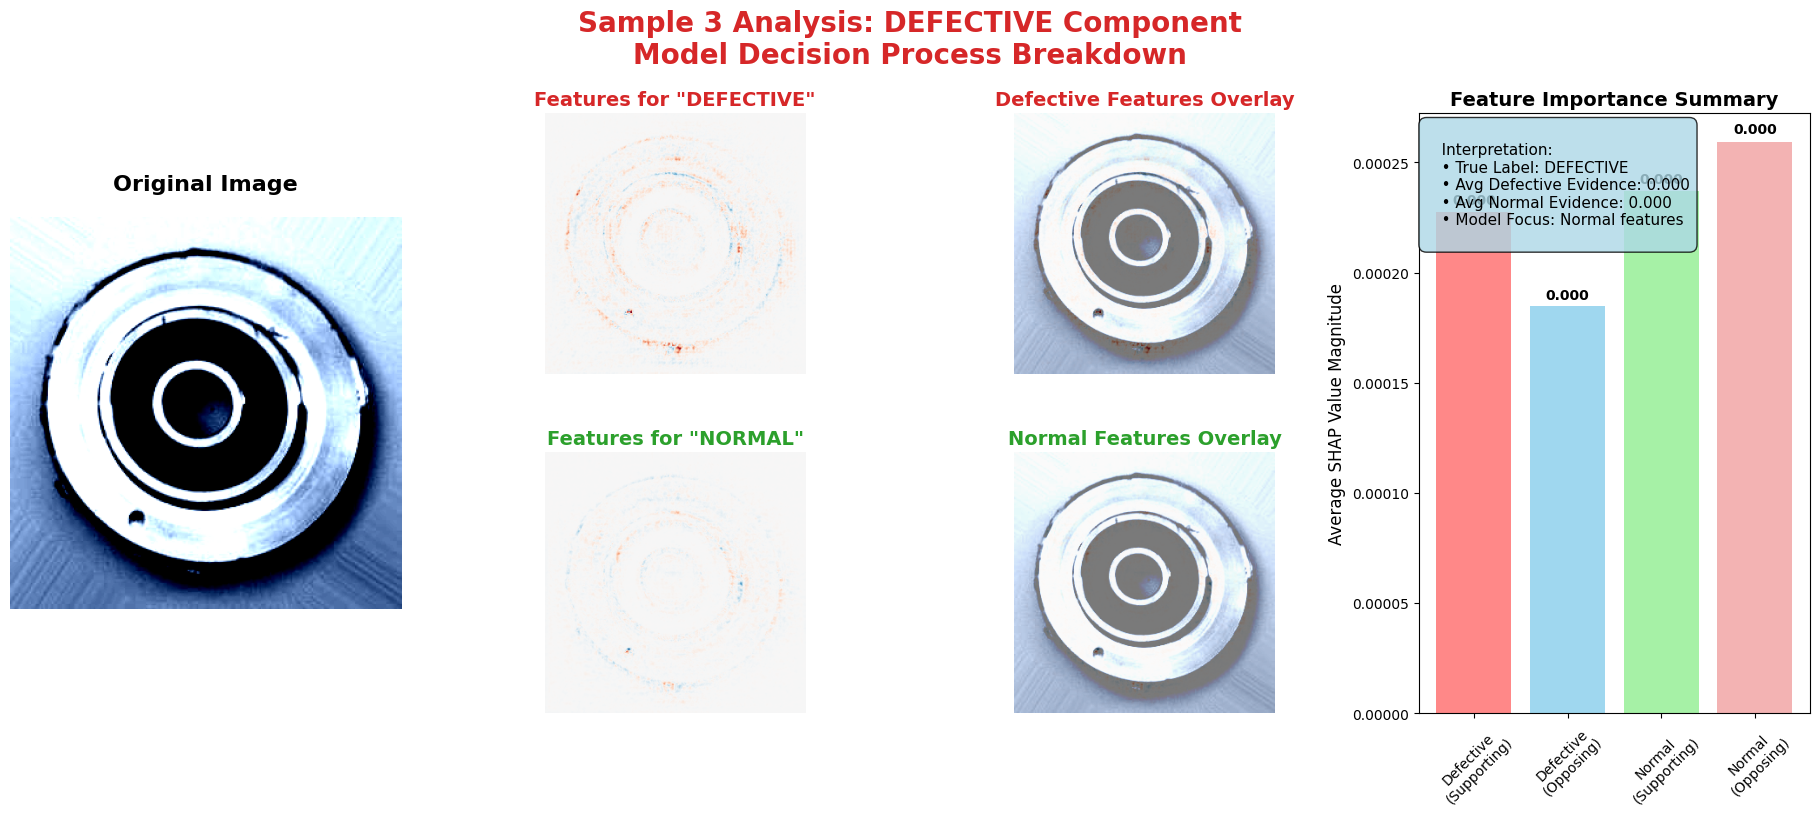

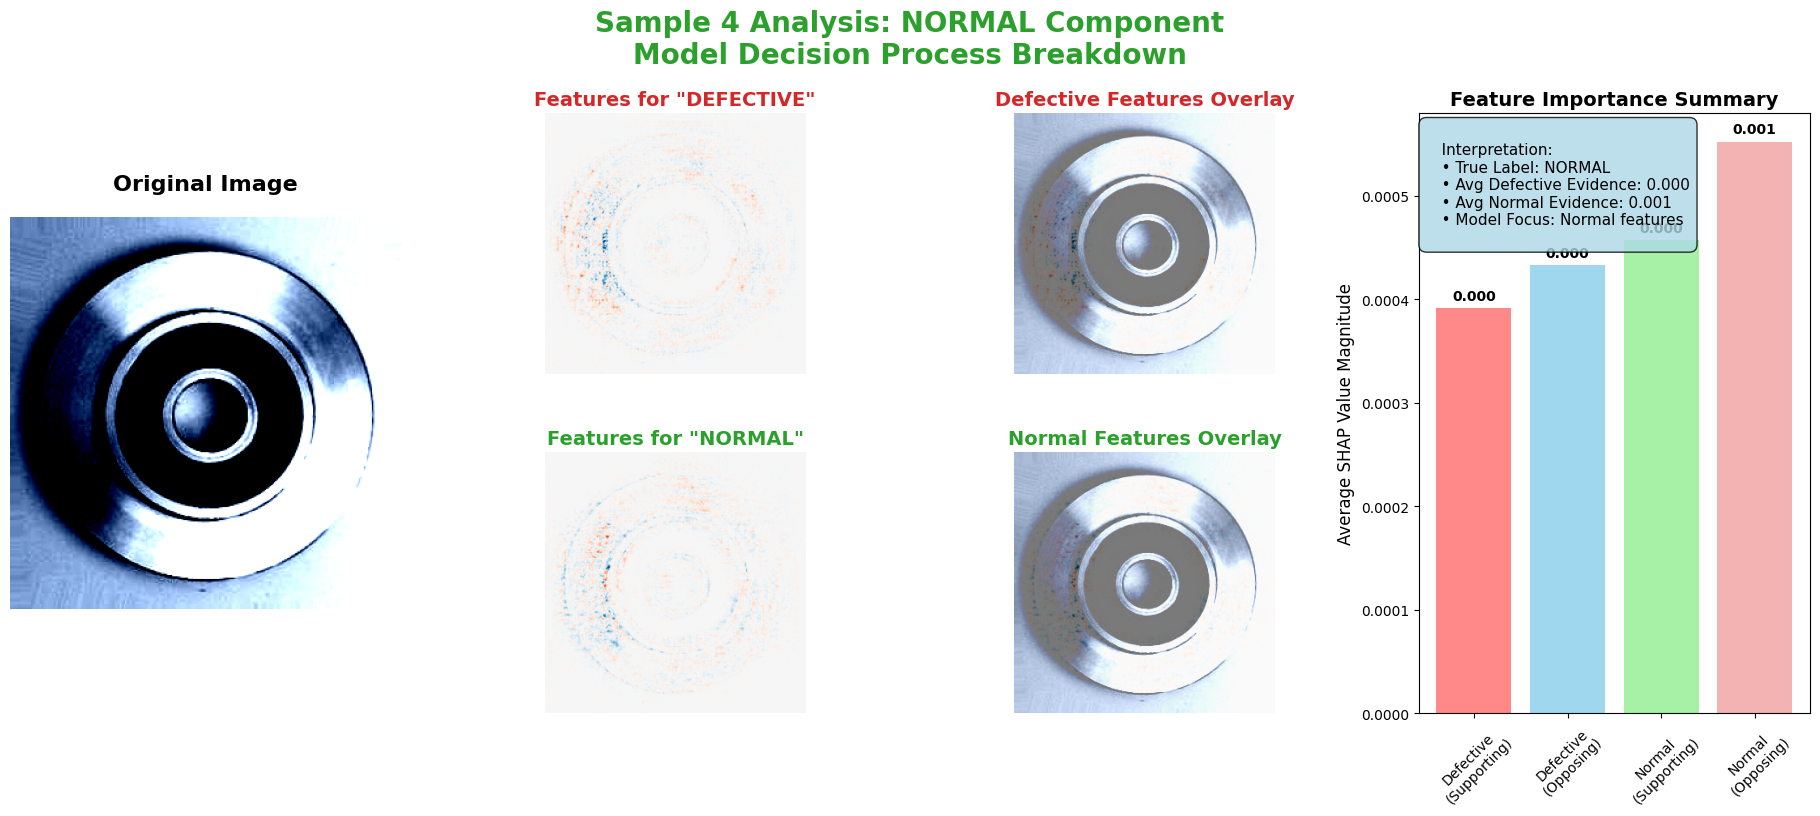

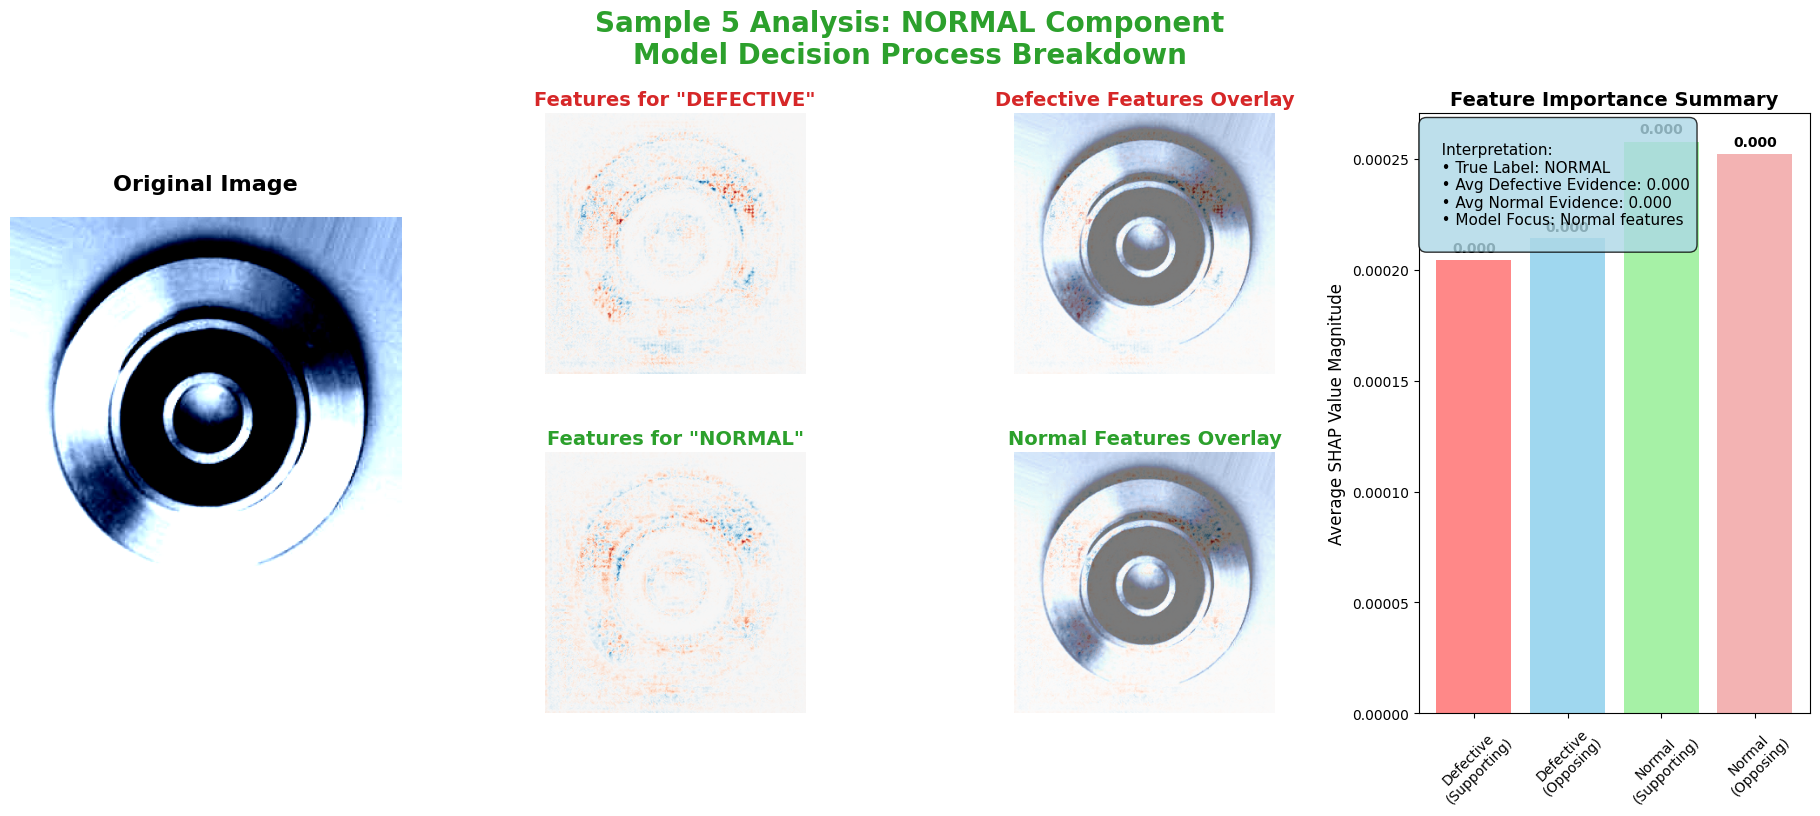

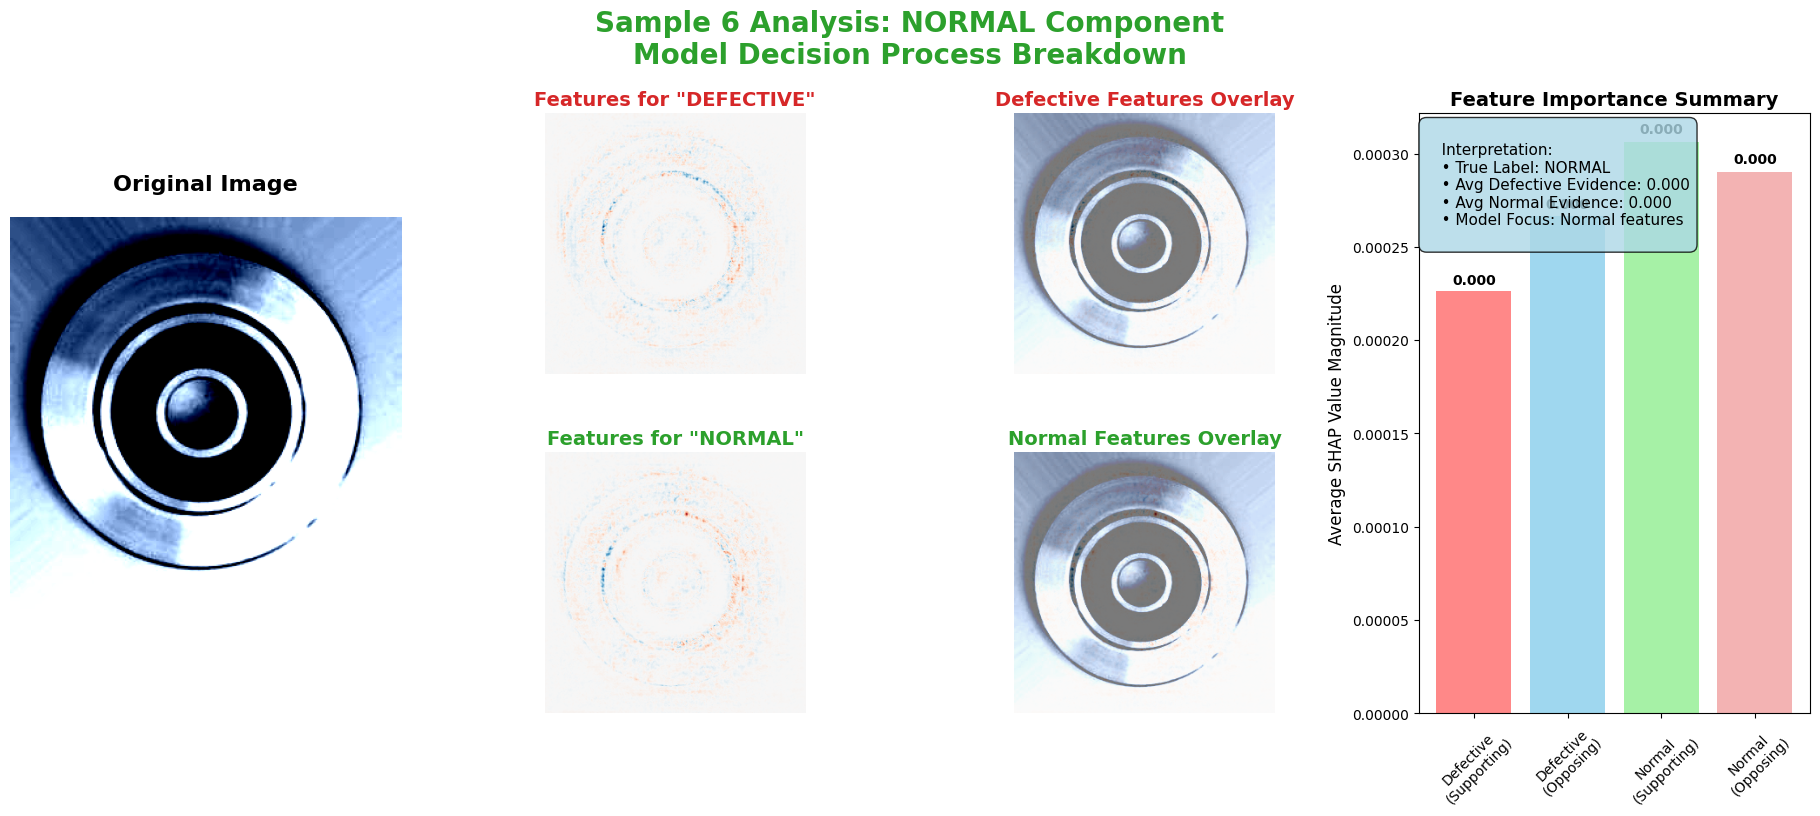

• Red regions indicate features that SUPPORT the prediction
• Blue regions indicate features that OPPOSE the prediction


In [17]:
print("Individual Analysis:")
for i, (img, label) in enumerate(zip(selected_imgs.cpu(), selected_labels)):
   img_np = img.numpy().transpose(1, 2, 0)
   img_np = np.clip(img_np, 0, 1)
   shap_def = shap_vals_defective[i]
   shap_norm = shap_vals_normal[i]
   fig = plt.figure(figsize=(20, 8))
   gs = fig.add_gridspec(2, 4, height_ratios=[1, 1], hspace=0.3, wspace=0.2)
   true_label = "DEFECTIVE" if label == 0 else "NORMAL"
   color = '#d62728' if label == 0 else '#2ca02c'
   fig.suptitle(f'Sample {i+1} Analysis: {true_label} Component\n' +
               'Model Decision Process Breakdown',
               fontsize=20, fontweight='bold', color=color)
   ax_orig = fig.add_subplot(gs[:, 0])
   ax_orig.imshow(img_np)
   ax_orig.set_title('Original Image', fontsize=16, fontweight='bold', pad=20)
   ax_orig.axis('off')
   for spine in ax_orig.spines.values():
       spine.set_edgecolor(color)
       spine.set_linewidth(4)
       spine.set_visible(True)
   ax_def = fig.add_subplot(gs[0, 1])
   max_val_def = np.abs(shap_def).max()
   im_def = ax_def.imshow(shap_def, cmap='RdBu_r', vmin=-max_val_def, vmax=max_val_def)
   ax_def.set_title('Features for "DEFECTIVE"', fontsize=14, fontweight='bold', color='#d62728')
   ax_def.axis('off')
   ax_def_overlay = fig.add_subplot(gs[0, 2])
   ax_def_overlay.imshow(img_np)
   ax_def_overlay.imshow(shap_def, cmap='RdBu_r', alpha=0.5, vmin=-max_val_def, vmax=max_val_def)
   ax_def_overlay.set_title('Defective Features Overlay', fontsize=14, fontweight='bold', color='#d62728')
   ax_def_overlay.axis('off')
   ax_norm = fig.add_subplot(gs[1, 1])
   max_val_norm = np.abs(shap_norm).max()
   im_norm = ax_norm.imshow(shap_norm, cmap='RdBu_r', vmin=-max_val_norm, vmax=max_val_norm)
   ax_norm.set_title('Features for "NORMAL"', fontsize=14, fontweight='bold', color='#2ca02c')
   ax_norm.axis('off')
   ax_norm_overlay = fig.add_subplot(gs[1, 2])
   ax_norm_overlay.imshow(img_np)
   ax_norm_overlay.imshow(shap_norm, cmap='RdBu_r', alpha=0.5, vmin=-max_val_norm, vmax=max_val_norm)
   ax_norm_overlay.set_title('Normal Features Overlay', fontsize=14, fontweight='bold', color='#2ca02c')
   ax_norm_overlay.axis('off')
   ax_summary = fig.add_subplot(gs[:, 3])
   def_importance = np.mean(np.abs(shap_def))
   norm_importance = np.mean(np.abs(shap_norm))
   def_positive = np.mean(shap_def[shap_def > 0]) if np.any(shap_def > 0) else 0
   def_negative = np.mean(shap_def[shap_def < 0]) if np.any(shap_def < 0) else 0
   norm_positive = np.mean(shap_norm[shap_norm > 0]) if np.any(shap_norm > 0) else 0
   norm_negative = np.mean(shap_norm[shap_norm < 0]) if np.any(shap_norm < 0) else 0
   categories = ['Defective\n(Supporting)', 'Defective\n(Opposing)',
                'Normal\n(Supporting)', 'Normal\n(Opposing)']
   values = [def_positive, abs(def_negative), norm_positive, abs(norm_negative)]
   colors = ['#ff6b6b', '#87ceeb', '#90ee90', '#f0a0a0']
   bars = ax_summary.bar(categories, values, color=colors, alpha=0.8)
   ax_summary.set_title('Feature Importance Summary', fontsize=14, fontweight='bold')
   ax_summary.set_ylabel('Average SHAP Value Magnitude', fontsize=12)
   ax_summary.tick_params(axis='x', rotation=45)
   for bar, value in zip(bars, values):
       height = bar.get_height()
       ax_summary.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                     f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
   interpretation = f"""
   Interpretation:
   • True Label: {true_label}
   • Avg Defective Evidence: {def_importance:.3f}
   • Avg Normal Evidence: {norm_importance:.3f}
   • Model Focus: {'Defective features' if def_importance > norm_importance else 'Normal features'}
   """
   ax_summary.text(0.02, 0.98, interpretation, transform=ax_summary.transAxes,
                  fontsize=11, verticalalignment='top',
                  bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))
   plt.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.1, hspace=0.3, wspace=0.2)
   plt.show()
print("• Red regions indicate features that SUPPORT the prediction")
print("• Blue regions indicate features that OPPOSE the prediction")

Summary Statistics and Model Insights:


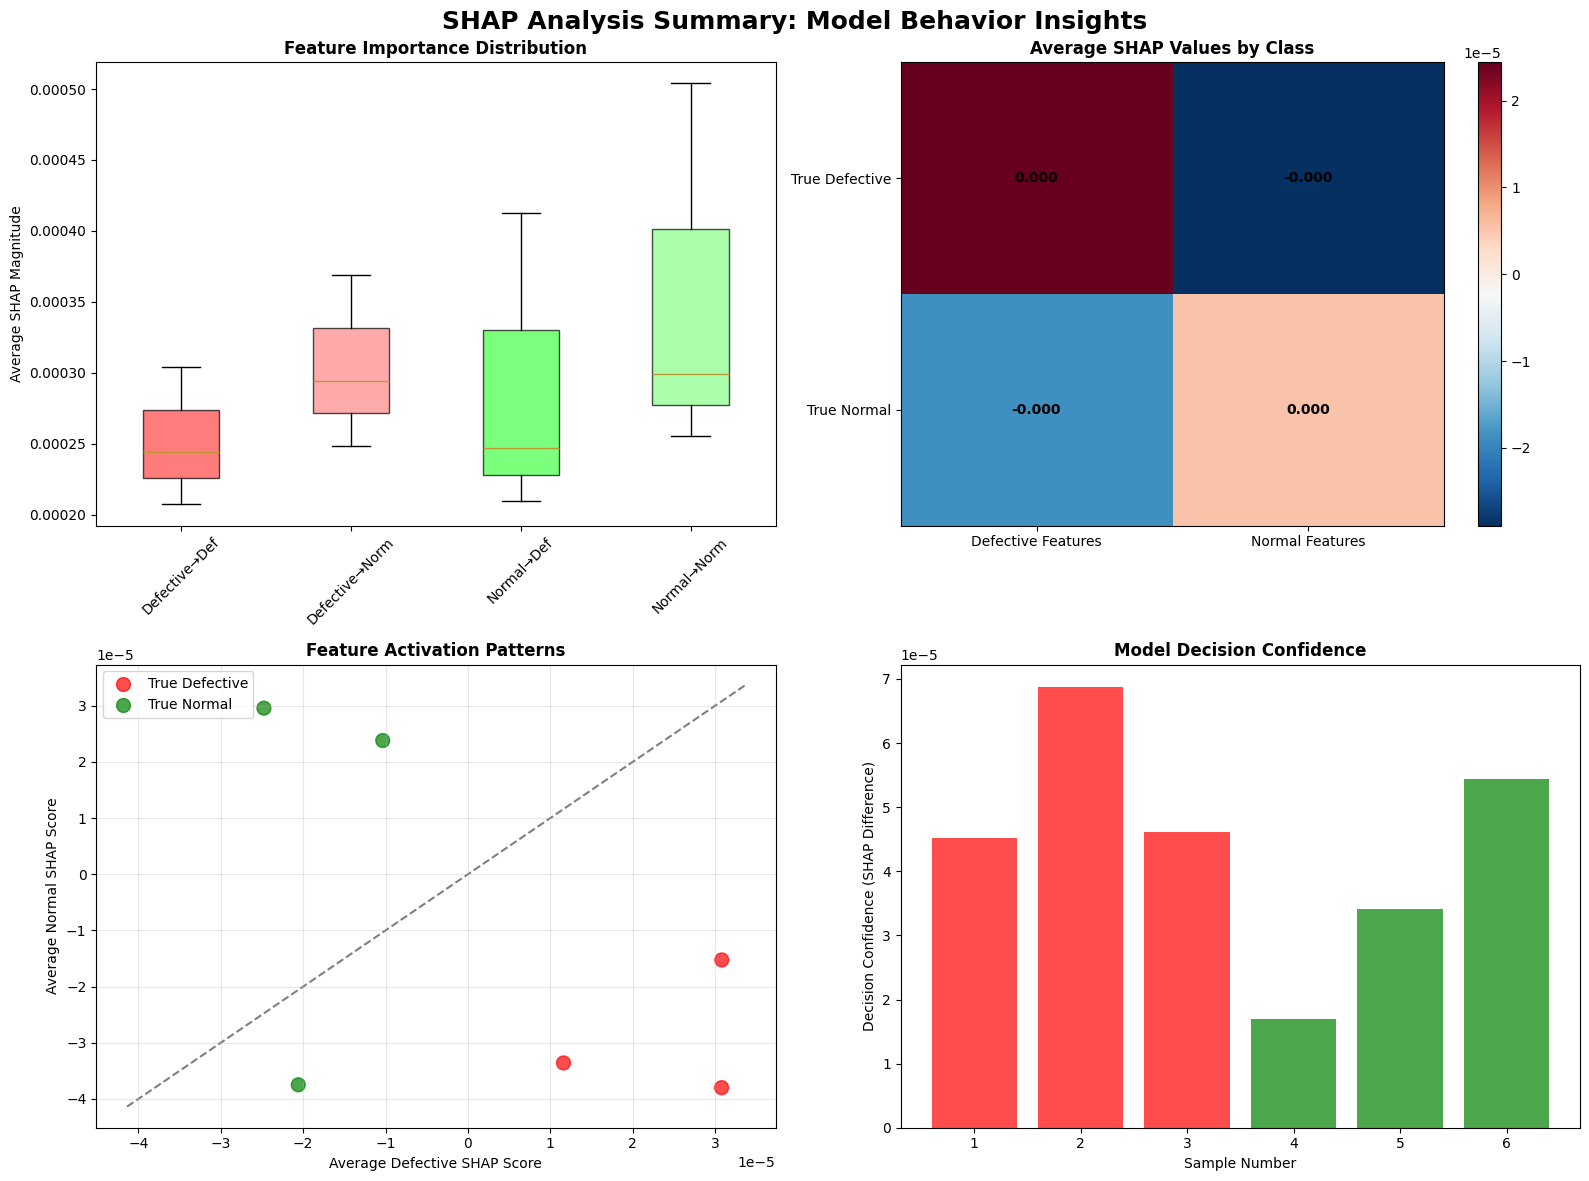

In [18]:
print("Summary Statistics and Model Insights:")
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('SHAP Analysis Summary: Model Behavior Insights', fontsize=18, fontweight='bold')
defective_samples = [i for i, label in enumerate(selected_labels) if label == 0]
normal_samples = [i for i, label in enumerate(selected_labels) if label == 1]
def_importance_def = [np.mean(np.abs(shap_vals_defective[i])) for i in defective_samples]
def_importance_norm = [np.mean(np.abs(shap_vals_normal[i])) for i in defective_samples]
norm_importance_def = [np.mean(np.abs(shap_vals_defective[i])) for i in normal_samples]
norm_importance_norm = [np.mean(np.abs(shap_vals_normal[i])) for i in normal_samples]
data_to_plot = [def_importance_def, def_importance_norm, norm_importance_def, norm_importance_norm]
labels_plot = ['Defective→Def', 'Defective→Norm', 'Normal→Def', 'Normal→Norm']
colors = ['#ff4444', '#ff8888', '#44ff44', '#88ff88']
bp = ax1.boxplot(data_to_plot, tick_labels=labels_plot, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
   patch.set_facecolor(color)
   patch.set_alpha(0.7)
ax1.set_title('Feature Importance Distribution', fontweight='bold')
ax1.set_ylabel('Average SHAP Magnitude')
ax1.tick_params(axis='x', rotation=45)
avg_shap_matrix = np.array([
   [np.mean([np.mean(shap_vals_defective[i]) for i in defective_samples]),
    np.mean([np.mean(shap_vals_normal[i]) for i in defective_samples])],
   [np.mean([np.mean(shap_vals_defective[i]) for i in normal_samples]),
    np.mean([np.mean(shap_vals_normal[i]) for i in normal_samples])]
])
im = ax2.imshow(avg_shap_matrix, cmap='RdBu_r', aspect='auto')
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['Defective Features', 'Normal Features'])
ax2.set_yticks([0, 1])
ax2.set_yticklabels(['True Defective', 'True Normal'])
ax2.set_title('Average SHAP Values by Class', fontweight='bold')
for i in range(2):
   for j in range(2):
       text = ax2.text(j, i, f'{avg_shap_matrix[i, j]:.3f}',
                     ha="center", va="center", color="black", fontweight='bold')
plt.colorbar(im, ax=ax2)
sample_indices = list(range(len(selected_labels)))
def_scores = [np.mean(shap_vals_defective[i]) for i in sample_indices]
norm_scores = [np.mean(shap_vals_normal[i]) for i in sample_indices]
colors_scatter = ['red' if label == 0 else 'green' for label in selected_labels]
scatter = ax3.scatter(def_scores, norm_scores, c=colors_scatter, alpha=0.7, s=100)
ax3.set_xlabel('Average Defective SHAP Score')
ax3.set_ylabel('Average Normal SHAP Score')
ax3.set_title('Feature Activation Patterns', fontweight='bold')
ax3.grid(True, alpha=0.3)
lims = [min(ax3.get_xlim()[0], ax3.get_ylim()[0]),
       max(ax3.get_xlim()[1], ax3.get_ylim()[1])]
ax3.plot(lims, lims, 'k--', alpha=0.5, zorder=0)
ax3.scatter([], [], c='red', alpha=0.7, s=100, label='True Defective')
ax3.scatter([], [], c='green', alpha=0.7, s=100, label='True Normal')
ax3.legend()
confidence_scores = []
for i in range(len(selected_labels)):
   def_score = np.mean(shap_vals_defective[i])
   norm_score = np.mean(shap_vals_normal[i])
   confidence = abs(def_score - norm_score)
   confidence_scores.append(confidence)
ax4.bar(range(1, len(confidence_scores)+1), confidence_scores,
      color=['red' if label == 0 else 'green' for label in selected_labels], alpha=0.7)
ax4.set_xlabel('Sample Number')
ax4.set_ylabel('Decision Confidence (SHAP Difference)')
ax4.set_title('Model Decision Confidence', fontweight='bold')
ax4.set_xticks(range(1, len(confidence_scores)+1))
plt.tight_layout()
plt.show()

In most `Defective` cases, SHAP highlights rough surface edges or dark regions.
In `Normal` predictions, smooth uniform areas contribute most to high confidence.
This aligns well with our intuition of manufacturing defects.